In [72]:
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# this makes the random number generation reproducable: 
np.random.seed(seed=9)

In [73]:
NE0=250 # number of cells in horizontal direction
NE1=250 # number of cells in vertical direction
h0=150. # in horizontal meter [m] grid spacing
h1=150. # in vertical meter [m] grid spacing

In [74]:
L0, L1=NE0*h0, NE1*h1

In [75]:
from esys.escript import *
from esys.finley import Rectangle
domain=Rectangle(l0=L0, l1=L1, n0=NE0, n1=NE1)

In [76]:
H_data=25000

In [77]:
surface_z=int(H_data/h1)*h1
surface_z+h1/2,L1

(24975.0, 37500.0)

Set up anomaly:

In [78]:
D=1000
H=2000+2000
W=2000
OFFSET=500

In [79]:
X=ReducedFunction(domain).getX()
m1=whereNonPositive(X[1]-(surface_z-D))
m2=whereNonNegative(X[1]-(surface_z-D-H))
m3=whereNonNegative(X[0]-(L0/2+OFFSET-W/2))
m4=whereNonPositive(X[0]-(L0/2+OFFSET+W/2))
m=m1*m2*m3*m4

In [80]:
m_surf=whereNonPositive(X[1]-surface_z)

Text(0, 0.5, '$x_1$ [m]')

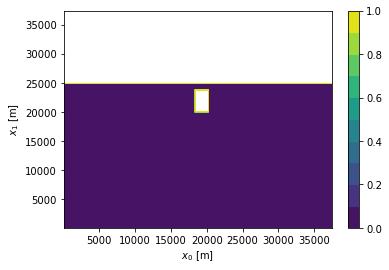

In [81]:
m_np=convertToNumpy((1-m_surf)+m)
X_np=convertToNumpy(m.getX())

plt.figure()
contour=plt.tricontourf(X_np[0], X_np[1], m_np[0], 10)
plt.colorbar(contour)
plt.xlabel('$x_0$ [m]')
plt.ylabel('$x_1$ [m]')

True density and conductivity distribution:

In [82]:
f=5
sigma1=2
sigma_bg=0.01
rho1=1500
error=0.01

In [83]:
sigma_true=(m*sigma1+(1-m)*sigma_bg)*m_surf
rho_true=(m*rho1)*m_surf

Model data:

In [84]:
from mytools import getMTTE, Mu0, getGravity, mGal, InversionJoint2DGravMTTE

In [85]:
data_mt=getMTTE(domain, f, sigma_true)

In [86]:
data_g=getGravity(domain, rho_true)

add noise:

In [87]:
data_mt*=(1+error*(2*RandomData((), data_mt.getFunctionSpace())-1))
data_g*=(1+error*(2*RandomData((), data_g.getFunctionSpace())-1))

where to calculate the misfit:

In [88]:
m_data=whereNegative(abs(X[1]-(surface_z+h1/2))-h1/2)*whereNegative(abs(X[0]-L0/2)-L0*0.45)

Text(0, 0.5, '$x_1$ [m]')

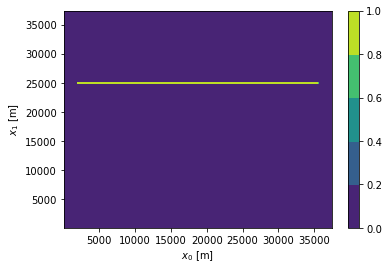

In [89]:
plt.figure()
contour=plt.tricontourf(X_np[0], X_np[1], convertToNumpy(m_data)[0], 5)
plt.colorbar(contour)
plt.xlabel('$x_0$ [m]')
plt.ylabel('$x_1$ [m]')

In [90]:
alpha_g=error**2
alpha_mt=1./800
mu_g, mu_mt=5.e-10, 5e-5
theta=100* 2/(1/mu_g+1/mu_mt)
theta=min(mu_g, mu_mt)*1000. # x 100 x10 x10 x10

In [92]:
alpha_g=error**2    * 1       #/500**2
alpha_mt=error**2   *100     
mu_g, mu_mt=1e6,1e6
theta=100000000

mu_g, mu_mt=1e5,1e5
theta=1e8*0

 set up `Wd`s:

In [93]:
Wd=interpolate(m_data, Function(domain))
Wd/=integrate(Wd)

In [94]:
Wd_mt=alpha_mt*Wd/abs(error*abs(data_mt))**2
Wd_g=alpha_g*Wd/abs(error*abs(data_g))**2

This is the cost function:

In [95]:
sigma_ref=sigma_bg*m_surf

In [96]:
cf=InversionJoint2DGravMTTE(domain, z_surface=surface_z, theta=theta,
                 data_g=data_g, Wd_g=Wd_g, rho_ref=0., rhodash=500., mu_g=mu_g,
                 f=f, data_mt=data_mt, Wd_mt=Wd_mt, sigma_ref=sigma_ref, mu_mt=mu_mt)

Ready to run the inversion:

In [97]:
from esys.downunder import MinimizerLBFGS
solver=MinimizerLBFGS(J=cf, m_tol=1e-3, J_tol=None, imax=500)
solver.setOptions(interpolationOrder=1, truncation=25, restart=60)
m=Data(0., (2,), Solution(domain))
solver.run(m)
mi=solver.getResult()

inv.minimizer.MinimizerLBFGS: Setting options: {'interpolationOrder': 1, 'truncation': 25, 'restart': 60}
inv: sigma= Summary: inf=0 sup=0.01 data points=250000
inv: rho= 0
inv.minimizer.MinimizerLBFGS: initial grad J(x) calculated.
inv: phi_d_g , phi_r_g  = 5.000000e-01, 0.000000e+00
inv: phi_d_mt, phi_r_mt = 1.570231e+00, 0.000000e+00
inv: phi_c            = 0.000000e+00
inv.minimizer.MinimizerLBFGS: ********** iteration   0 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 2.0702305470940834
inv.minimizer.MinimizerLBFGS: 	H = 1.0
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=31.6872 (re-scale = 0.000141972, invH = 1)


gz Summary: inf=-0 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: phi(0)=2.070231e+00
inv.minimizer.linesearch: phi'(0)=-1.004081e+03
inv: sigma= Summary: inf=0 sup=0.0193693 data points=250000
inv: rho= Summary: inf=0 sup=15843.5 data points=250000
inv: phi_d_g , phi_r_g  = 5.629362e+05, 7.120381e-02
inv: phi_d_mt, phi_r_mt = 8.884837e-01, 7.188498e-05
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.000000e+00, phi(alpha)=5.629371e+05


gz Summary: inf=-0.219892 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv: sigma= Summary: inf=0 sup=0.0139174 data points=250000
inv: rho= Summary: inf=0 sup=7921.75 data points=250000
inv: phi_d_g , phi_r_g  = 1.404837e+05, 1.780095e-02
inv: phi_d_mt, phi_r_mt = 1.152357e+00, 1.797125e-05
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch.zoom: iteration 0, alpha=0.5, phi(alpha)=140485 (interpolation order = 1)
inv: sigma= Summary: inf=0 sup=0.0117972 data points=250000


gz Summary: inf=-0.109946 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv: rho= Summary: inf=0 sup=3960.87 data points=250000
inv: phi_d_g , phi_r_g  = 3.499590e+04, 4.450238e-03
inv: phi_d_mt, phi_r_mt = 1.339899e+00, 4.492811e-06
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch.zoom: iteration 1, alpha=0.25, phi(alpha)=34997.2 (interpolation order = 1)


gz Summary: inf=-0.054973 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv: sigma= Summary: inf=0 sup=0.0108615 data points=250000
inv: rho= Summary: inf=0 sup=1980.44 data points=250000
inv: phi_d_g , phi_r_g  = 8.686659e+03, 1.112560e-03
inv: phi_d_mt, phi_r_mt = 1.449446e+00, 1.123203e-06
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch.zoom: iteration 2, alpha=0.125, phi(alpha)=8688.11 (interpolation order = 1)
inv: sigma= Summary: inf=0 sup=0.0104218 data points=250000


gz Summary: inf=-0.0274865 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv: rho= Summary: inf=0 sup=990.219 data points=250000
inv: phi_d_g , phi_r_g  = 2.140694e+03, 2.781399e-04
inv: phi_d_mt, phi_r_mt = 1.508400e+00, 2.808007e-07
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch.zoom: iteration 3, alpha=0.0625, phi(alpha)=2142.2 (interpolation order = 1)
inv: sigma= Summary: inf=0 sup=0.0102087 data points=250000


gz Summary: inf=-0.0137433 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv: rho= Summary: inf=0 sup=495.109 data points=250000
inv: phi_d_g , phi_r_g  = 5.198755e+02, 6.953497e-05
inv: phi_d_mt, phi_r_mt = 1.538951e+00, 7.020018e-08
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch.zoom: iteration 4, alpha=0.03125, phi(alpha)=521.415 (interpolation order = 1)
inv: sigma= Summary: inf=0 sup=0.0101038 data points=250000


gz Summary: inf=-0.00687163 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv: rho= Summary: inf=0 sup=247.555 data points=250000
inv: phi_d_g , phi_r_g  = 1.225074e+02, 1.738374e-05
inv: phi_d_mt, phi_r_mt = 1.554499e+00, 1.755004e-08
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch.zoom: iteration 5, alpha=0.015625, phi(alpha)=124.062 (interpolation order = 1)


gz Summary: inf=-0.00343581 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv: sigma= Summary: inf=0 sup=0.0100518 data points=250000
inv: rho= Summary: inf=0 sup=123.777 data points=250000
inv: phi_d_g , phi_r_g  = 2.708362e+01, 4.345936e-06
inv: phi_d_mt, phi_r_mt = 1.562342e+00, 4.387511e-09
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch.zoom: iteration 6, alpha=0.0078125, phi(alpha)=28.646 (interpolation order = 1)


gz Summary: inf=-0.00171791 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv: sigma= Summary: inf=0 sup=0.0100259 data points=250000
inv: rho= Summary: inf=0 sup=61.8887 data points=250000
inv: phi_d_g , phi_r_g  = 5.186786e+00, 1.086484e-06
inv: phi_d_mt, phi_r_mt = 1.566281e+00, 1.096878e-09
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch.zoom: iteration 7, alpha=0.00390625, phi(alpha)=6.75307 (interpolation order = 1)
inv: sigma= Summary: inf=0 sup=0.0100129 data points=250000


gz Summary: inf=-0.000858953 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv: rho= Summary: inf=0 sup=30.9443 data points=250000
inv: phi_d_g , phi_r_g  = 6.921372e-01, 2.716210e-07
inv: phi_d_mt, phi_r_mt = 1.568254e+00, 2.742194e-10
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch.zoom: iteration 8, alpha=0.00195312, phi(alpha)=2.26039 (interpolation order = 1)
inv: sigma= Summary: inf=0 sup=0.0100065 data points=250000


gz Summary: inf=-0.000429477 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv: rho= Summary: inf=0 sup=15.4722 data points=250000
inv: phi_d_g , phi_r_g  = 5.825473e-02, 6.790525e-08
inv: phi_d_mt, phi_r_mt = 1.569242e+00, 6.855486e-11
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch.zoom: iteration 9, alpha=0.000976562, phi(alpha)=1.6275 (interpolation order = 1)


gz Summary: inf=-0.000214738 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch.zoom: 	phi'(alpha)=9.736246e+01
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=9.765625e-04
inv.minimizer.MinimizerLBFGS: Solution checked: dx=3.094457e-02, x*m_tol=3.094457e-05
inv.minimizer.MinimizerLBFGS: ********** iteration   1 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 1.627496772557036
inv.minimizer.MinimizerLBFGS: 	H = 0.0008902389528156603
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.00145893 (re-scale = 3.13364e-07, invH = 0.000890239)
inv.minimizer.linesearch: phi(0)=1.627497e+00
inv.minimizer.linesearch: phi'(0)=-1.079557e-02
inv: sigma= Summary: inf=0 sup=0.0100065 data points=250000
inv: rho= Summary: inf=0 sup=15.4707 data points=250000
inv: phi_d_g , phi_r_g  = 5.824629e-02, 6.789355e-08
inv: phi_d_mt, phi_r_mt = 1.569240e+00, 6.884609e-11
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=9.765625e-04, phi(alpha)=1.62748

gz Summary: inf=-0.000214719 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-1.078736e-02
inv: sigma= Summary: inf=0 sup=0.0100065 data points=250000
inv: rho= Summary: inf=0 sup=15.4693 data points=250000
inv: phi_d_g , phi_r_g  = 5.823785e-02, 6.788185e-08
inv: phi_d_mt, phi_r_mt = 1.569238e+00, 6.913794e-11
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 2, alpha=1.953125e-03, phi(alpha)=1.627476e+00


gz Summary: inf=-0.0002147 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-1.077915e-02
inv: sigma= Summary: inf=0 sup=0.0100065 data points=250000
inv: rho= Summary: inf=0 sup=15.4663 data points=250000
inv: phi_d_g , phi_r_g  = 5.822101e-02, 6.785845e-08
inv: phi_d_mt, phi_r_mt = 1.569234e+00, 6.972349e-11
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 3, alpha=3.906250e-03, phi(alpha)=1.627455e+00


gz Summary: inf=-0.000214662 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-1.076272e-02
inv: sigma= Summary: inf=0 sup=0.0100066 data points=250000
inv: rho= Summary: inf=0 sup=15.4605 data points=250000
inv: phi_d_g , phi_r_g  = 5.818742e-02, 6.781166e-08
inv: phi_d_mt, phi_r_mt = 1.569225e+00, 7.090199e-11
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 4, alpha=7.812500e-03, phi(alpha)=1.627413e+00


gz Summary: inf=-0.000214587 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-1.072987e-02
inv: sigma= Summary: inf=0 sup=0.0100067 data points=250000
inv: rho= Summary: inf=0 sup=15.4489 data points=250000
inv: phi_d_g , phi_r_g  = 5.812062e-02, 6.771814e-08
inv: phi_d_mt, phi_r_mt = 1.569208e+00, 7.328862e-11
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 5, alpha=1.562500e-02, phi(alpha)=1.627329e+00


gz Summary: inf=-0.000214435 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-1.066416e-02
inv: sigma= Summary: inf=0 sup=0.0100069 data points=250000
inv: rho= Summary: inf=0 sup=15.4256 data points=250000
inv: phi_d_g , phi_r_g  = 5.798857e-02, 6.753130e-08
inv: phi_d_mt, phi_r_mt = 1.569175e+00, 7.818041e-11
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 6, alpha=3.125000e-02, phi(alpha)=1.627164e+00


gz Summary: inf=-0.000214131 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-1.053275e-02
inv: sigma= Summary: inf=0 sup=0.0100073 data points=250000
inv: rho= Summary: inf=0 sup=15.3789 data points=250000
inv: phi_d_g , phi_r_g  = 5.773062e-02, 6.715844e-08
inv: phi_d_mt, phi_r_mt = 1.569108e+00, 8.843805e-11
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 7, alpha=6.250000e-02, phi(alpha)=1.626838e+00


gz Summary: inf=-0.000213524 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-1.026993e-02
inv: sigma= Summary: inf=0 sup=0.0100082 data points=250000
inv: rho= Summary: inf=0 sup=15.2857 data points=250000
inv: phi_d_g , phi_r_g  = 5.723935e-02, 6.641595e-08
inv: phi_d_mt, phi_r_mt = 1.568974e+00, 1.108496e-10
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 8, alpha=1.250000e-01, phi(alpha)=1.626213e+00


gz Summary: inf=-0.000212311 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-9.744275e-03
inv: sigma= Summary: inf=0 sup=0.01001 data points=250000
inv: rho= Summary: inf=0 sup=15.0993 data points=250000
inv: phi_d_g , phi_r_g  = 5.635534e-02, 6.494394e-08
inv: phi_d_mt, phi_r_mt = 1.568705e+00, 1.632580e-10
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 9, alpha=2.500000e-01, phi(alpha)=1.625061e+00


gz Summary: inf=-0.000209889 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-8.692946e-03
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=2.500000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=7.457835e-04, x*m_tol=3.019879e-05
inv.minimizer.MinimizerLBFGS: ********** iteration   2 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 1.6250607038883718
inv.minimizer.MinimizerLBFGS: 	H = 0.001058092666420789
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.00172665 (re-scale = 3.71546e-07, invH = 0.00105809)
inv.minimizer.linesearch: phi(0)=1.625061e+00
inv.minimizer.linesearch: phi'(0)=-1.247850e-02
inv: sigma= Summary: inf=0 sup=0.010019 data points=250000
inv: rho= Summary: inf=0 sup=14.7607 data points=250000
inv: phi_d_g , phi_r_g  = 5.488927e-02, 6.197832e-08
inv: phi_d_mt, phi_r_mt = 1.567333e+00, 5.898313e-10
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=2.500000e-01, phi(alpha)=1.622222e+00


gz Summary: inf=-0.000205091 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-1.022937e-02
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=2.500000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=8.979704e-04, x*m_tol=2.952166e-05
inv.minimizer.MinimizerLBFGS: ********** iteration   3 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 1.6222222156161328
inv.minimizer.MinimizerLBFGS: 	H = 0.0014340694019846492
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.00232534 (re-scale = 5.01825e-07, invH = 0.00143407)
inv.minimizer.linesearch: phi(0)=1.622222e+00
inv.minimizer.linesearch: phi'(0)=-1.741693e-02
inv: sigma= Summary: inf=0 sup=0.0100381 data points=250000
inv: rho= Summary: inf=0 sup=14.4489 data points=250000
inv: phi_d_g , phi_r_g  = 5.381481e-02, 5.879130e-08
inv: phi_d_mt, phi_r_mt = 1.564418e+00, 2.378829e-09
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=2.500000e-01, phi(alpha)=1.618232e+00

gz Summary: inf=-0.000199969 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-1.450126e-02
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=2.500000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=1.910863e-03, x*m_tol=2.889808e-05
inv.minimizer.MinimizerLBFGS: ********** iteration   4 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 1.618232442561267
inv.minimizer.MinimizerLBFGS: 	H = 0.005009330217249519
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.00803806 (re-scale = 1.74371e-06, invH = 0.00500933)
inv.minimizer.linesearch: phi(0)=1.618232e+00
inv.minimizer.linesearch: phi'(0)=-3.574199e-02
inv: sigma= Summary: inf=0 sup=0.0100896 data points=250000
inv: rho= Summary: inf=0 sup=14.1728 data points=250000
inv: phi_d_g , phi_r_g  = 5.321761e-02, 5.556242e-08
inv: phi_d_mt, phi_r_mt = 1.556651e+00, 1.305613e-08
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=2.500000e-01, phi(alpha)=1.609869e+00


gz Summary: inf=-0.000194239 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-3.116591e-02
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=2.500000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=5.113141e-03, x*m_tol=2.834573e-05
inv.minimizer.MinimizerLBFGS: ********** iteration   5 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 1.6098689660574923
inv.minimizer.MinimizerLBFGS: 	H = 0.022852925970994177
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.0354369 (re-scale = 7.85183e-06, invH = 0.0228529)
inv.minimizer.linesearch: phi(0)=1.609869e+00
inv.minimizer.linesearch: phi'(0)=-1.288893e-01
inv: sigma= Summary: inf=0 sup=0.0102989 data points=250000
inv: rho= Summary: inf=0 sup=14.0534 data points=250000
inv: phi_d_g , phi_r_g  = 5.349572e-02, 5.728585e-08
inv: phi_d_mt, phi_r_mt = 1.525943e+00, 1.421103e-07
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=2.500000e-01, phi(alpha)=1.579439e+00


gz Summary: inf=-0.000187093 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-1.145528e-01
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=2.500000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=2.054815e-02, x*m_tol=2.946683e-05
inv.minimizer.MinimizerLBFGS: ********** iteration   6 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 1.5794393658853503
inv.minimizer.MinimizerLBFGS: 	H = 0.11780469278630559
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.16002 (re-scale = 3.96678e-05, invH = 0.117805)
inv.minimizer.linesearch: phi(0)=1.579439e+00
inv.minimizer.linesearch: phi'(0)=-5.441891e-01
inv: sigma= Summary: inf=0 sup=0.0112862 data points=250000
inv: rho= Summary: inf=-3.85676 sup=15.5184 data points=250000
inv: phi_d_g , phi_r_g  = 5.512173e-02, 1.674226e-07
inv: phi_d_mt, phi_r_mt = 1.398536e+00, 2.364031e-06
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=2.500000e-01, phi(alpha)=1.453660e+00

gz Summary: inf=-0.00018494 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-4.624868e-01
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=2.500000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=9.160466e-02, x*m_tol=1.210715e-04
inv.minimizer.MinimizerLBFGS: ********** iteration   7 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 1.4536600700051707
inv.minimizer.MinimizerLBFGS: 	H = 0.41082877490999414
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.781492 (re-scale = 0.000147313, invH = 0.410829)
inv.minimizer.linesearch: phi(0)=1.453660e+00
inv.minimizer.linesearch: phi'(0)=-2.272790e+00
inv: sigma= Summary: inf=0 sup=0.0166821 data points=250000
inv: rho= Summary: inf=-95.798 sup=89.2601 data points=250000
inv: phi_d_g , phi_r_g  = 8.112954e-01, 6.645126e-06
inv: phi_d_mt, phi_r_mt = 9.931665e-01, 4.060491e-05
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=2.500000e-01, phi(alpha)=1.804509e+00

gz Summary: inf=-0.000475344 sup=0.000180181 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv: sigma= Summary: inf=0 sup=0.013721 data points=250000
inv: rho= Summary: inf=-47.3134 sup=49.0809 data points=250000
inv: phi_d_g , phi_r_g  = 2.278679e-01, 1.967026e-06
inv: phi_d_mt, phi_r_mt = 1.172312e+00, 1.563024e-05
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch.zoom: iteration 0, alpha=0.125, phi(alpha)=1.4002 (interpolation order = 1)


gz Summary: inf=-0.000314996 sup=1.13718e-05 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch.zoom: 	phi'(alpha)=1.410456e+00
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=1.955148e-01, x*m_tol=3.165863e-04
inv.minimizer.MinimizerLBFGS: ********** iteration   8 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 1.4001978869414415
inv.minimizer.MinimizerLBFGS: 	H = 0.08302688136741214
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.135357 (re-scale = 2.99825e-05, invH = 0.0830269)
inv.minimizer.linesearch: phi(0)=1.400198e+00
inv.minimizer.linesearch: phi'(0)=-1.022031e+00
inv: sigma= Summary: inf=0 sup=0.0148879 data points=250000
inv: rho= Summary: inf=-47.8374 sup=42.3166 data points=250000
inv: phi_d_g , phi_r_g  = 1.876121e-01, 2.170430e-06
inv: phi_d_mt, phi_r_mt = 1.091866e+00, 2.468164e-05
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=1.279

gz Summary: inf=-0.00028614 sup=4.52417e-06 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-9.095920e-01
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=8.167251e-02, x*m_tol=3.982588e-04
inv.minimizer.MinimizerLBFGS: ********** iteration   9 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 1.2795052024345803
inv.minimizer.MinimizerLBFGS: 	H = 0.47459610790142726
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.26789 (re-scale = 0.000187524, invH = 0.474596)
inv.minimizer.linesearch: phi(0)=1.279505e+00
inv.minimizer.linesearch: phi'(0)=-1.125453e+00
inv: sigma= Summary: inf=0 sup=0.016661 data points=250000
inv: rho= Summary: inf=-46.7111 sup=42.6105 data points=250000
inv: phi_d_g , phi_r_g  = 1.500987e-01, 2.433523e-06
inv: phi_d_mt, phi_r_mt = 9.963969e-01, 3.942777e-05
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=1.146537e+00


gz Summary: inf=-0.000278345 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-1.002711e+00
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=1.128702e-01, x*m_tol=5.106940e-04
inv.minimizer.MinimizerLBFGS: ********** iteration  10 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 1.1465373845137496
inv.minimizer.MinimizerLBFGS: 	H = 0.8303359278470492
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.644081 (re-scale = 0.000996411, invH = 0.830336)
inv.minimizer.linesearch: phi(0)=1.146537e+00
inv.minimizer.linesearch: phi'(0)=-1.536011e+00
inv: sigma= Summary: inf=0 sup=0.0209657 data points=250000
inv: rho= Summary: inf=-44.5178 sup=52.766 data points=250000
inv: phi_d_g , phi_r_g  = 1.227942e-01, 3.290007e-06
inv: phi_d_mt, phi_r_mt = 8.423087e-01, 7.634946e-05
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=9.651826e-01


gz Summary: inf=-0.000277417 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-1.362548e+00
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=2.330977e-01, x*m_tol=7.413475e-04
inv.minimizer.MinimizerLBFGS: ********** iteration  11 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.9651825872423183
inv.minimizer.MinimizerLBFGS: 	H = 2.5058805218445515
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=1.69204 (re-scale = 0.00127328, invH = 2.50588)
inv.minimizer.linesearch: phi(0)=9.651826e-01
inv.minimizer.linesearch: phi'(0)=-2.555016e+00
inv: sigma= Summary: inf=0 sup=0.033175 data points=250000
inv: rho= Summary: inf=-44.9772 sup=76.019 data points=250000
inv: phi_d_g , phi_r_g  = 7.235736e-02, 6.146425e-06
inv: phi_d_mt, phi_r_mt = 6.119639e-01, 1.930090e-04
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=6.845204e-01


gz Summary: inf=-0.000332125 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-1.915078e+00
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=4.645670e-01, x*m_tol=1.200968e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  12 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.6845204116223524
inv.minimizer.MinimizerLBFGS: 	H = 2.6980432917962474
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=2.91041 (re-scale = 0.00277884, invH = 2.69804)
inv.minimizer.linesearch: phi(0)=6.845204e-01
inv.minimizer.linesearch: phi'(0)=-4.210560e+00
inv: sigma= Summary: inf=0 sup=0.0949477 data points=250000
inv: rho= Summary: inf=-48.5689 sup=108.596 data points=250000
inv: phi_d_g , phi_r_g  = 5.278297e-02, 1.319046e-05
inv: phi_d_mt, phi_r_mt = 2.633832e-01, 7.310773e-04
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=3.169104e-01


gz Summary: inf=-0.000315918 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-1.540116e+00
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=1.069192e+00, x*m_tol=2.250999e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  13 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.3169104103308863
inv.minimizer.MinimizerLBFGS: 	H = 3.4246605188421384
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=1.48994 (re-scale = 0.00357736, invH = 3.42466)
inv.minimizer.linesearch: phi(0)=3.169104e-01
inv.minimizer.linesearch: phi'(0)=-1.019021e+00
inv: sigma= Summary: inf=0 sup=0.13481 data points=250000
inv: rho= Summary: inf=-66.6073 sup=162.802 data points=250000
inv: phi_d_g , phi_r_g  = 4.373133e-02, 2.750891e-05
inv: phi_d_mt, phi_r_mt = 1.914398e-01, 9.895953e-04
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=2.361883e-01


gz Summary: inf=-0.000435949 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-2.719466e-01
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=3.697572e-01, x*m_tol=2.609522e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  14 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.2361882537475068
inv.minimizer.MinimizerLBFGS: 	H = 1.464061491333437
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.959603 (re-scale = 0.00165592, invH = 1.46406)
inv.minimizer.linesearch: phi(0)=2.361883e-01
inv.minimizer.linesearch: phi'(0)=-8.269463e-01
inv: sigma= Summary: inf=0 sup=0.194396 data points=250000
inv: rho= Summary: inf=-62.9221 sup=161.417 data points=250000
inv: phi_d_g , phi_r_g  = 1.654320e-02, 2.792026e-05
inv: phi_d_mt, phi_r_mt = 1.393919e-01, 1.294976e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=1.572580e-01


gz Summary: inf=-0.000417324 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-4.402138e-01
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=3.847197e-01, x*m_tol=2.979734e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  15 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.15725800088623643
inv.minimizer.MinimizerLBFGS: 	H = 3.0617391757647776
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=1.42519 (re-scale = 0.00385068, invH = 3.06174)
inv.minimizer.linesearch: phi(0)=1.572580e-01
inv.minimizer.linesearch: phi'(0)=-7.587334e-01
inv: sigma= Summary: inf=0 sup=0.279647 data points=250000
inv: rho= Summary: inf=-70.3571 sup=197.86 data points=250000
inv: phi_d_g , phi_r_g  = 9.734414e-03, 4.095687e-05
inv: phi_d_mt, phi_r_mt = 9.286867e-02, 1.675080e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=1.043191e-01


gz Summary: inf=-0.000499448 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-8.627818e-02
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=3.916028e-01, x*m_tol=3.335914e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  16 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.10431912452448516
inv.minimizer.MinimizerLBFGS: 	H = 1.824392425904922
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.322582 (re-scale = 0.00177497, invH = 1.82439)
inv.minimizer.linesearch: phi(0)=1.043191e-01
inv.minimizer.linesearch: phi'(0)=-1.272283e-01
inv: sigma= Summary: inf=0 sup=0.311133 data points=250000
inv: rho= Summary: inf=-74.3696 sup=204.868 data points=250000
inv: phi_d_g , phi_r_g  = 8.380925e-03, 4.413564e-05
inv: phi_d_mt, phi_r_mt = 8.009758e-02, 1.807617e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=9.033025e-02


gz Summary: inf=-0.000500262 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-9.675879e-02
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=1.171021e-01, x*m_tol=3.439824e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  17 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.09033025424522496
inv.minimizer.MinimizerLBFGS: 	H = 3.6004274256650497
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.875806 (re-scale = 0.00433322, invH = 3.60043)
inv.minimizer.linesearch: phi(0)=9.033025e-02
inv.minimizer.linesearch: phi'(0)=-2.805307e-01
inv: sigma= Summary: inf=0 sup=0.414274 data points=250000
inv: rho= Summary: inf=-81.6777 sup=221.214 data points=250000
inv: phi_d_g , phi_r_g  = 5.199430e-03, 5.229400e-05
inv: phi_d_mt, phi_r_mt = 5.593356e-02, 2.182822e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=6.336811e-02


gz Summary: inf=-0.000509329 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-1.527247e-01
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=3.135619e-01, x*m_tol=3.732150e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  18 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.06336810678030023
inv.minimizer.MinimizerLBFGS: 	H = 6.1543947682368545
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=1.05479 (re-scale = 0.00722704, invH = 6.15439)
inv.minimizer.linesearch: phi(0)=6.336811e-02
inv.minimizer.linesearch: phi'(0)=-2.309661e-01
inv: sigma= Summary: inf=0 sup=0.532231 data points=250000
inv: rho= Summary: inf=-94.5422 sup=239.164 data points=250000
inv: phi_d_g , phi_r_g  = 5.989872e-03, 6.235859e-05
inv: phi_d_mt, phi_r_mt = 5.517130e-02, 2.575184e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=6.379871e-02


gz Summary: inf=-0.000520702 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv: sigma= Summary: inf=0 sup=0.469563 data points=250000
inv: rho= Summary: inf=-87.6332 sup=230.048 data points=250000
inv: phi_d_g , phi_r_g  = 5.066331e-03, 5.701081e-05
inv: phi_d_mt, phi_r_mt = 4.870542e-02, 2.371798e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch.zoom: iteration 0, alpha=0.0625, phi(alpha)=0.0562006 (interpolation order = 1)


gz Summary: inf=-0.000515016 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch.zoom: 	phi'(alpha)=2.519708e-03
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=6.250000e-02
inv.minimizer.MinimizerLBFGS: Solution checked: dx=1.422751e-01, x*m_tol=3.862648e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  19 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.05620056174747007
inv.minimizer.MinimizerLBFGS: 	H = 1.3871299479709125
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.141602 (re-scale = 0.0015019, invH = 1.38713)
inv.minimizer.linesearch: phi(0)=5.620056e-02
inv.minimizer.linesearch: phi'(0)=-6.029402e-02
inv: sigma= Summary: inf=0 sup=0.490145 data points=250000
inv: rho= Summary: inf=-89.6305 sup=233.815 data points=250000
inv: phi_d_g , phi_r_g  = 4.698795e-03, 5.901131e-05
inv: phi_d_mt, phi_r_mt = 4.535503e-02, 2.439167e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=6.250000e-02, phi(alpha)=5.255200e-

gz Summary: inf=-0.000516725 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-5.647184e-02
inv: sigma= Summary: inf=0 sup=0.51163 data points=250000
inv: rho= Summary: inf=-91.695 sup=237.613 data points=250000
inv: phi_d_g , phi_r_g  = 4.356145e-03, 6.107313e-05
inv: phi_d_mt, phi_r_mt = 4.221508e-02, 2.507826e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 2, alpha=1.250000e-01, phi(alpha)=4.914012e-02


gz Summary: inf=-0.000518434 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-5.271970e-02
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=9.517308e-02, x*m_tol=3.951779e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  20 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.04914012273108763
inv.minimizer.MinimizerLBFGS: 	H = 9.566965920633011
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.659236 (re-scale = 0.00698358, invH = 9.56697)
inv.minimizer.linesearch: phi(0)=4.914012e-02
inv.minimizer.linesearch: phi'(0)=-9.244213e-02
inv: sigma= Summary: inf=0 sup=0.584778 data points=250000
inv: rho= Summary: inf=-98.5364 sup=253.278 data points=250000
inv: phi_d_g , phi_r_g  = 3.780244e-03, 6.902156e-05
inv: phi_d_mt, phi_r_mt = 3.498125e-02, 2.746354e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=4.157687e-02


gz Summary: inf=-0.000529923 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-2.893400e-02
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=1.534309e-01, x*m_tol=4.090746e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  21 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.04157687322219114
inv.minimizer.MinimizerLBFGS: 	H = 2.96542093203863
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.335979 (re-scale = 0.00346646, invH = 2.96542)
inv.minimizer.linesearch: phi(0)=4.157687e-02
inv.minimizer.linesearch: phi'(0)=-7.289456e-02
inv: sigma= Summary: inf=0 sup=0.657668 data points=250000
inv: rho= Summary: inf=-101.009 sup=265.893 data points=250000
inv: phi_d_g , phi_r_g  = 2.882160e-03, 7.605734e-05
inv: phi_d_mt, phi_r_mt = 2.781974e-02, 2.967175e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=3.374513e-02


gz Summary: inf=-0.000535236 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-5.253730e-02
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=1.357612e-01, x*m_tol=4.212776e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  22 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.033745128456446845
inv.minimizer.MinimizerLBFGS: 	H = 7.24305843856463
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=1.00438 (re-scale = 0.00779218, invH = 7.24306)
inv.minimizer.linesearch: phi(0)=3.374513e-02
inv.minimizer.linesearch: phi'(0)=-1.616327e-01
inv: sigma= Summary: inf=0 sup=0.873433 data points=250000
inv: rho= Summary: inf=-117.845 sup=298.626 data points=250000
inv: phi_d_g , phi_r_g  = 2.005215e-03, 9.651793e-05
inv: phi_d_mt, phi_r_mt = 1.821502e-02, 3.531395e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=2.384815e-02


gz Summary: inf=-0.000552105 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=2.613288e-03
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=3.231964e-01, x*m_tol=4.499511e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  23 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.023848147292689185
inv.minimizer.MinimizerLBFGS: 	H = 5.087778493550353
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.292514 (re-scale = 0.00804665, invH = 5.08778)
inv.minimizer.linesearch: phi(0)=2.384815e-02
inv.minimizer.linesearch: phi'(0)=-3.224476e-02
inv: sigma= Summary: inf=0 sup=0.935199 data points=250000
inv: rho= Summary: inf=-123.834 sup=310.186 data points=250000
inv: phi_d_g , phi_r_g  = 2.052662e-03, 1.040103e-04
inv: phi_d_mt, phi_r_mt = 1.501923e-02, 3.679728e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=2.085563e-02


gz Summary: inf=-0.000559792 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-1.563251e-02
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=7.716409e-02, x*m_tol=4.565460e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  24 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.02085562954454651
inv.minimizer.MinimizerLBFGS: 	H = 2.867425385091041
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.296818 (re-scale = 0.00737814, invH = 2.86743)
inv.minimizer.linesearch: phi(0)=2.085563e-02
inv.minimizer.linesearch: phi'(0)=-4.178914e-02
inv: sigma= Summary: inf=0 sup=1.03694 data points=250000
inv: rho= Summary: inf=-126.946 sup=326.313 data points=250000
inv: phi_d_g , phi_r_g  = 1.375204e-03, 1.152521e-04
inv: phi_d_mt, phi_r_mt = 1.179040e-02, 3.913419e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=1.719427e-02


gz Summary: inf=-0.000566174 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-1.682974e-02
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=1.162053e-01, x*m_tol=4.665269e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  25 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.017194274762358606
inv.minimizer.MinimizerLBFGS: 	H = 4.32820391104476
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.479544 (re-scale = 0.00762932, invH = 4.3282)
inv.minimizer.linesearch: phi(0)=1.719427e-02
inv.minimizer.linesearch: phi'(0)=-5.811752e-02
inv: sigma= Summary: inf=0 sup=1.21845 data points=250000
inv: rho= Summary: inf=-137.683 sup=354.904 data points=250000
inv: phi_d_g , phi_r_g  = 1.148229e-03, 1.360153e-04
inv: phi_d_mt, phi_r_mt = 7.612011e-03, 4.295984e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=1.319224e-02


gz Summary: inf=-0.000584563 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-6.135148e-03
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=1.819314e-01, x*m_tol=4.821203e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  26 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.013192238859750958
inv.minimizer.MinimizerLBFGS: 	H = 5.093887476187613
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.258186 (re-scale = 0.00838019, invH = 5.09389)
inv.minimizer.linesearch: phi(0)=1.319224e-02
inv.minimizer.linesearch: phi'(0)=-1.534321e-02
inv: sigma= Summary: inf=0 sup=1.29857 data points=250000
inv: rho= Summary: inf=-140.36 sup=362.511 data points=250000
inv: phi_d_g , phi_r_g  = 9.144497e-04, 1.422253e-04
inv: phi_d_mt, phi_r_mt = 6.526109e-03, 4.433824e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=1.201661e-02


gz Summary: inf=-0.000586524 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-3.472134e-03
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=7.155041e-02, x*m_tol=4.882761e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  27 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.012016607888804218
inv.minimizer.MinimizerLBFGS: 	H = 3.450039897044923
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.0845607 (re-scale = 0.00753277, invH = 3.45004)
inv.minimizer.linesearch: phi(0)=1.201661e-02
inv.minimizer.linesearch: phi'(0)=-3.959494e-03
inv: sigma= Summary: inf=0 sup=1.33624 data points=250000
inv: rho= Summary: inf=-141.407 sup=367.526 data points=250000
inv: phi_d_g , phi_r_g  = 8.481112e-04, 1.459679e-04
inv: phi_d_mt, phi_r_mt = 6.068566e-03, 4.499415e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=1.156206e-02


gz Summary: inf=-0.00058895 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-3.314003e-03
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=3.261006e-02, x*m_tol=4.910269e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  28 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.011562059293314265
inv.minimizer.MinimizerLBFGS: 	H = 13.179621046573663
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.396556 (re-scale = 0.0201576, invH = 13.1796)
inv.minimizer.linesearch: phi(0)=1.156206e-02
inv.minimizer.linesearch: phi'(0)=-1.427279e-02
inv: sigma= Summary: inf=0 sup=1.49235 data points=250000
inv: rho= Summary: inf=-145.572 sup=390.266 data points=250000
inv: phi_d_g , phi_r_g  = 6.367814e-04, 1.633151e-04
inv: phi_d_mt, phi_r_mt = 5.154931e-03, 4.758608e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=1.071364e-02


gz Summary: inf=-0.000601513 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=6.614640e-04
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=1.262021e-01, x*m_tol=5.016663e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  29 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.010713636297445348
inv.minimizer.MinimizerLBFGS: 	H = 8.53177819398578
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.147736 (re-scale = 0.0124796, invH = 8.53178)
inv.minimizer.linesearch: phi(0)=1.071364e-02
inv.minimizer.linesearch: phi'(0)=-4.628311e-03
inv: sigma= Summary: inf=0 sup=1.54257 data points=250000
inv: rho= Summary: inf=-147.25 sup=397.682 data points=250000
inv: phi_d_g , phi_r_g  = 5.762276e-04, 1.691393e-04
inv: phi_d_mt, phi_r_mt = 4.632452e-03, 4.837771e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=1.021559e-02


gz Summary: inf=-0.000605467 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-3.340546e-03
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=3.774907e-02, x*m_tol=5.048506e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  30 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.010215590502710094
inv.minimizer.MinimizerLBFGS: 	H = 8.852501149959563
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.126617 (re-scale = 0.00167481, invH = 8.8525)
inv.minimizer.linesearch: phi(0)=1.021559e-02
inv.minimizer.linesearch: phi'(0)=-3.651280e-03
inv: sigma= Summary: inf=0 sup=1.59293 data points=250000
inv: rho= Summary: inf=-149.665 sup=404.509 data points=250000
inv: phi_d_g , phi_r_g  = 5.983659e-04, 1.747982e-04
inv: phi_d_mt, phi_r_mt = 4.271299e-03, 4.904097e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=9.948560e-03


gz Summary: inf=-0.000606728 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-6.171143e-04
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=3.888562e-02, x*m_tol=5.078817e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  31 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.009948560070698501
inv.minimizer.MinimizerLBFGS: 	H = 3.9868406630876927
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.121142 (re-scale = 0.000580929, invH = 3.98684)
inv.minimizer.linesearch: phi(0)=9.948560e-03
inv.minimizer.linesearch: phi'(0)=-5.104676e-03
inv: sigma= Summary: inf=0 sup=1.66787 data points=250000
inv: rho= Summary: inf=-152.212 sup=414.434 data points=250000
inv: phi_d_g , phi_r_g  = 5.218939e-04, 1.831289e-04
inv: phi_d_mt, phi_r_mt = 3.711189e-03, 5.017115e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=9.433327e-03


gz Summary: inf=-0.000612832 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-3.143821e-03
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=5.125715e-02, x*m_tol=5.123354e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  32 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.009433326699357706
inv.minimizer.MinimizerLBFGS: 	H = 10.71897820825784
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.749083 (re-scale = 0.00138156, invH = 10.719)
inv.minimizer.linesearch: phi(0)=9.433327e-03
inv.minimizer.linesearch: phi'(0)=-5.338879e-02
inv: sigma= Summary: inf=0 sup=2.12464 data points=250000
inv: rho= Summary: inf=-207.85 sup=510.371 data points=250000
inv: phi_d_g , phi_r_g  = 3.372808e-02, 2.902593e-04
inv: phi_d_mt, phi_r_mt = 9.893643e-03, 5.980390e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=4.989237e-02
inv:

gz Summary: inf=-0.000634732 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv: rho= Summary: inf=-175.749 sup=461.366 data points=250000
inv: phi_d_g , phi_r_g  = 8.183001e-03, 2.302052e-04
inv: phi_d_mt, phi_r_mt = 4.108572e-03, 5.457886e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch.zoom: iteration 0, alpha=0.0625, phi(alpha)=0.0179797 (interpolation order = 1)


gz Summary: inf=-0.000623771 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv: sigma= Summary: inf=0 sup=1.75349 data points=250000
inv: rho= Summary: inf=-162.574 sup=437.57 data points=250000
inv: phi_d_g , phi_r_g  = 2.116951e-03, 2.050448e-04
inv: phi_d_mt, phi_r_mt = 3.198983e-03, 5.227284e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch.zoom: iteration 1, alpha=0.03125, phi(alpha)=0.0107483 (interpolation order = 1)
inv: sigma= Summary: inf=0 sup=1.71014 data points=250000


gz Summary: inf=-0.00061829 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv: rho= Summary: inf=-156.98 sup=425.953 data points=250000
inv: phi_d_g , phi_r_g  = 7.605481e-04, 1.936813e-04
inv: phi_d_mt, phi_r_mt = 3.272653e-03, 5.119645e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch.zoom: iteration 2, alpha=0.015625, phi(alpha)=0.00934653 (interpolation order = 1)
inv.minimizer.linesearch: grad J(x+alpha*p) calculated.


gz Summary: inf=-0.00061555 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch.zoom: 	phi'(alpha)=4.217830e-02
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.562500e-02
inv.minimizer.MinimizerLBFGS: Solution checked: dx=4.796566e-02, x*m_tol=5.145598e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  33 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.009346527846558386
inv.minimizer.MinimizerLBFGS: 	H = 1.5407508312814477
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.00916022 (re-scale = 0.0010308, invH = 1.54075)
inv.minimizer.linesearch: phi(0)=9.346528e-03
inv.minimizer.linesearch: phi'(0)=-1.122836e-03
inv: sigma= Summary: inf=0 sup=1.71189 data points=250000
inv: rho= Summary: inf=-157.044 sup=426.172 data points=250000
inv: phi_d_g , phi_r_g  = 7.488703e-04, 1.938745e-04
inv: phi_d_mt, phi_r_mt = 3.264416e-03, 5.121943e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.562500e-02, phi(alpha)=9.329104e-03


gz Summary: inf=-0.000615688 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-1.107420e-03
inv: sigma= Summary: inf=0 sup=1.71365 data points=250000
inv: rho= Summary: inf=-157.109 sup=426.391 data points=250000
inv: phi_d_g , phi_r_g  = 7.373565e-04, 1.940680e-04
inv: phi_d_mt, phi_r_mt = 3.256253e-03, 5.124243e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 2, alpha=3.125000e-02, phi(alpha)=9.311921e-03


gz Summary: inf=-0.000615826 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-1.092005e-03
inv: sigma= Summary: inf=0 sup=1.71717 data points=250000
inv: rho= Summary: inf=-157.239 sup=426.829 data points=250000
inv: phi_d_g , phi_r_g  = 7.148208e-04, 1.944559e-04
inv: phi_d_mt, phi_r_mt = 3.240152e-03, 5.128849e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 3, alpha=6.250000e-02, phi(alpha)=9.278277e-03


gz Summary: inf=-0.000616103 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-1.061178e-03
inv: sigma= Summary: inf=0 sup=1.72422 data points=250000
inv: rho= Summary: inf=-157.498 sup=427.705 data points=250000
inv: phi_d_g , phi_r_g  = 6.717169e-04, 1.952354e-04
inv: phi_d_mt, phi_r_mt = 3.208844e-03, 5.138084e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 4, alpha=1.250000e-01, phi(alpha)=9.213880e-03


gz Summary: inf=-0.000616655 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-9.995313e-04
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=9.058367e-03, x*m_tol=5.153565e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  34 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.009213880356377529
inv.minimizer.MinimizerLBFGS: 	H = 5.323652773146366
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.0511674 (re-scale = 0.0163394, invH = 5.32365)
inv.minimizer.linesearch: phi(0)=9.213880e-03
inv.minimizer.linesearch: phi'(0)=-1.582641e-03
inv: sigma= Summary: inf=0 sup=1.74598 data points=250000
inv: rho= Summary: inf=-157.716 sup=431.193 data points=250000
inv: phi_d_g , phi_r_g  = 5.894045e-04, 1.980531e-04
inv: phi_d_mt, phi_r_mt = 3.081501e-03, 5.159562e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=9.028520e-03


gz Summary: inf=-0.000618523 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-1.383066e-03
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=1.520403e-02, x*m_tol=5.165429e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  35 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.009028520407013487
inv.minimizer.MinimizerLBFGS: 	H = 9.266177490945188
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.0972896 (re-scale = 0.00170607, invH = 9.26618)
inv.minimizer.linesearch: phi(0)=9.028520e-03
inv.minimizer.linesearch: phi'(0)=-2.370088e-03
inv: sigma= Summary: inf=0 sup=1.75464 data points=250000
inv: rho= Summary: inf=-157.773 sup=437.464 data points=250000
inv: phi_d_g , phi_r_g  = 4.833048e-04, 2.027712e-04
inv: phi_d_mt, phi_r_mt = 2.936569e-03, 5.179426e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=8.802071e-03


gz Summary: inf=-0.000622664 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-1.254513e-03
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=1.958142e-02, x*m_tol=5.169549e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  36 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.008802071217208387
inv.minimizer.MinimizerLBFGS: 	H = 2.7496663392209992
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.0342834 (re-scale = 0.000605083, invH = 2.74967)
inv.minimizer.linesearch: phi(0)=8.802071e-03
inv.minimizer.linesearch: phi'(0)=-1.433281e-03
inv: sigma= Summary: inf=0 sup=1.77768 data points=250000
inv: rho= Summary: inf=-158.426 sup=441.931 data points=250000
inv: phi_d_g , phi_r_g  = 4.127885e-04, 2.064531e-04
inv: phi_d_mt, phi_r_mt = 2.816167e-03, 5.201596e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=8.637005e-03

gz Summary: inf=-0.000624989 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-1.207579e-03
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.250000e-01
inv.minimizer.MinimizerLBFGS: Solution checked: dx=1.649399e-02, x*m_tol=5.181743e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  37 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.00863700511426987
inv.minimizer.MinimizerLBFGS: 	H = 9.642855655238888
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.04011 (re-scale = 0.00147523, invH = 9.64286)
inv.minimizer.linesearch: phi(0)=8.637005e-03
inv.minimizer.linesearch: phi'(0)=-1.021672e-03
inv: sigma= Summary: inf=0 sup=1.84205 data points=250000
inv: rho= Summary: inf=-156.344 sup=441.833 data points=250000
inv: phi_d_g , phi_r_g  = 3.637071e-04, 2.056677e-04
inv: phi_d_mt, phi_r_mt = 2.864600e-03, 5.230173e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.250000e-01, phi(alpha)=8.664148e-03


gz Summary: inf=-0.000624256 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv: sigma= Summary: inf=0 sup=1.80958 data points=250000
inv: rho= Summary: inf=-157.385 sup=441.882 data points=250000
inv: phi_d_g , phi_r_g  = 3.838147e-04, 2.060540e-04
inv: phi_d_mt, phi_r_mt = 2.806311e-03, 5.215703e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch.zoom: iteration 0, alpha=0.0625, phi(alpha)=0.00861188 (interpolation order = 1)


gz Summary: inf=-0.000624623 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch.zoom: 	phi'(alpha)=2.174496e-04
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=6.250000e-02
inv.minimizer.MinimizerLBFGS: Solution checked: dx=1.871240e-02, x*m_tol=5.200066e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  38 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.008611882623264346
inv.minimizer.MinimizerLBFGS: 	H = 4.521316645436232
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.315424 (re-scale = 0.000605809, invH = 4.52132)
inv.minimizer.linesearch: phi(0)=8.611883e-03
inv.minimizer.linesearch: phi'(0)=-2.280631e-02
inv: sigma= Summary: inf=0 sup=1.68838 data points=250000
inv: rho= Summary: inf=-152.941 sup=465.093 data points=250000
inv: phi_d_g , phi_r_g  = 1.108342e-03, 2.229351e-04
inv: phi_d_mt, phi_r_mt = 4.930380e-03, 5.125265e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=6.250000e-02, phi(alpha)=1.138692e

gz Summary: inf=-0.000654702 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv: sigma= Summary: inf=0 sup=1.74426 data points=250000
inv: rho= Summary: inf=-154.783 sup=453.487 data points=250000
inv: phi_d_g , phi_r_g  = 4.699675e-04, 2.140611e-04
inv: phi_d_mt, phi_r_mt = 3.100181e-03, 5.164863e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch.zoom: iteration 0, alpha=0.03125, phi(alpha)=0.00894907 (interpolation order = 1)


gz Summary: inf=-0.000639662 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv: sigma= Summary: inf=0 sup=1.77289 data points=250000
inv: rho= Summary: inf=-156.042 sup=447.685 data points=250000
inv: phi_d_g , phi_r_g  = 3.578634e-04, 2.099492e-04
inv: phi_d_mt, phi_r_mt = 2.761223e-03, 5.188878e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch.zoom: iteration 1, alpha=0.015625, phi(alpha)=0.00851791 (interpolation order = 1)


gz Summary: inf=-0.000632142 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch.zoom: 	phi'(alpha)=1.078539e-02
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.562500e-02
inv.minimizer.MinimizerLBFGS: Solution checked: dx=6.808340e-02, x*m_tol=5.178531e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  39 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.008517913246289074
inv.minimizer.MinimizerLBFGS: 	H = 8.831418383991616
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.293226 (re-scale = 0.00124927, invH = 8.83142)
inv.minimizer.linesearch: phi(0)=8.517913e-03
inv.minimizer.linesearch: phi'(0)=-1.027938e-02
inv: sigma= Summary: inf=0 sup=1.75055 data points=250000
inv: rho= Summary: inf=-157.352 sup=449.104 data points=250000
inv: phi_d_g , phi_r_g  = 2.948862e-04, 2.117670e-04
inv: phi_d_mt, phi_r_mt = 2.814496e-03, 5.171648e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.562500e-02, phi(alpha)=8.492797e-

gz Summary: inf=-0.00062804 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=7.066649e-03
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.562500e-02
inv.minimizer.MinimizerLBFGS: Solution checked: dx=2.844159e-02, x*m_tol=5.167036e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  40 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.008492797265360386
inv.minimizer.MinimizerLBFGS: 	H = 2.984609296665126
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.0248417 (re-scale = 0.000479369, invH = 2.98461)
inv.minimizer.linesearch: phi(0)=8.492797e-03
inv.minimizer.linesearch: phi'(0)=-6.988416e-04
inv: sigma= Summary: inf=0 sup=1.75354 data points=250000
inv: rho= Summary: inf=-157.42 sup=449.391 data points=250000
inv: phi_d_g , phi_r_g  = 2.937100e-04, 2.120294e-04
inv: phi_d_mt, phi_r_mt = 2.802469e-03, 5.173913e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=1.562500e-02, phi(alpha)=8.482121e-03


gz Summary: inf=-0.000628112 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-6.676851e-04
inv: sigma= Summary: inf=0 sup=1.75653 data points=250000
inv: rho= Summary: inf=-157.487 sup=449.679 data points=250000
inv: phi_d_g , phi_r_g  = 2.926160e-04, 2.122925e-04
inv: phi_d_mt, phi_r_mt = 2.790841e-03, 5.176182e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 2, alpha=3.125000e-02, phi(alpha)=8.471932e-03


gz Summary: inf=-0.000628185 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-6.365216e-04
inv: sigma= Summary: inf=0 sup=1.76252 data points=250000
inv: rho= Summary: inf=-157.653 sup=450.254 data points=250000
inv: phi_d_g , phi_r_g  = 2.906745e-04, 2.128209e-04
inv: phi_d_mt, phi_r_mt = 2.768787e-03, 5.180733e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 3, alpha=6.250000e-02, phi(alpha)=8.453015e-03


gz Summary: inf=-0.000628331 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-5.741743e-04
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=6.250000e-02
inv.minimizer.MinimizerLBFGS: Solution checked: dx=1.074251e-02, x*m_tol=5.173898e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  41 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.00845301495097412
inv.minimizer.MinimizerLBFGS: 	H = 14.810804310450132
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=1.15624 (re-scale = 0.00192646, invH = 14.8108)
inv.minimizer.linesearch: phi(0)=8.453015e-03
inv.minimizer.linesearch: phi'(0)=-9.064290e-02
inv: sigma= Summary: inf=0 sup=11.7021 data points=250000
inv: rho= Summary: inf=-219.227 sup=653.26 data points=250000
inv: phi_d_g , phi_r_g  = 9.334360e-02, 4.659452e-04
inv: phi_d_mt, phi_r_mt = 2.061028e-01, 8.612067e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=6.250000e-02, phi(alpha)=3.085244e-01


gz Summary: inf=-0.000920992 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv: sigma= Summary: inf=0 sup=4.49576 data points=250000
inv: rho= Summary: inf=-177.429 sup=551.034 data points=250000
inv: phi_d_g , phi_r_g  = 2.312157e-02, 3.140651e-04
inv: phi_d_mt, phi_r_mt = 5.184506e-02, 6.675737e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch.zoom: iteration 0, alpha=0.03125, phi(alpha)=0.0819564 (interpolation order = 1)


gz Summary: inf=-0.000774594 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv: sigma= Summary: inf=0 sup=2.80998 data points=250000
inv: rho= Summary: inf=-163.189 sup=500.393 data points=250000
inv: phi_d_g , phi_r_g  = 5.782229e-03, 2.571135e-04
inv: phi_d_mt, phi_r_mt = 1.419105e-02, 5.873069e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch.zoom: iteration 1, alpha=0.015625, phi(alpha)=0.0261035 (interpolation order = 1)


gz Summary: inf=-0.000701462 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv: sigma= Summary: inf=0 sup=2.22154 data points=250000
inv: rho= Summary: inf=-159.11 sup=475.243 data points=250000
inv: phi_d_g , phi_r_g  = 1.555478e-03, 2.333848e-04
inv: phi_d_mt, phi_r_mt = 5.210983e-03, 5.513110e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch.zoom: iteration 2, alpha=0.0078125, phi(alpha)=0.012513 (interpolation order = 1)


gz Summary: inf=-0.000664897 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv: sigma= Summary: inf=0 sup=1.97528 data points=250000
inv: rho= Summary: inf=-158.132 sup=462.706 data points=250000
inv: phi_d_g , phi_r_g  = 5.528331e-04, 2.227073e-04
inv: phi_d_mt, phi_r_mt = 3.172337e-03, 5.343473e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch.zoom: iteration 3, alpha=0.00390625, phi(alpha)=0.00929135 (interpolation order = 1)


gz Summary: inf=-0.000646614 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=0 data points=250000


inv: sigma= Summary: inf=0 sup=1.86433 data points=250000
inv: rho= Summary: inf=-157.8 sup=456.48 data points=250000
inv: phi_d_g , phi_r_g  = 3.291930e-04, 2.176652e-04
inv: phi_d_mt, phi_r_mt = 2.766031e-03, 5.261241e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch.zoom: iteration 4, alpha=0.00195312, phi(alpha)=0.00857413 (interpolation order = 1)


gz Summary: inf=-0.000637472 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv: sigma= Summary: inf=0 sup=1.81271 data points=250000
inv: rho= Summary: inf=-157.67 sup=453.367 data points=250000
inv: phi_d_g , phi_r_g  = 2.867935e-04, 2.152183e-04
inv: phi_d_mt, phi_r_mt = 2.716257e-03, 5.220772e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch.zoom: iteration 5, alpha=0.000976562, phi(alpha)=0.00843904 (interpolation order = 1)


gz Summary: inf=-0.000632902 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch.zoom: 	phi'(alpha)=6.201707e-02
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=9.765625e-04
inv.minimizer.MinimizerLBFGS: Solution checked: dx=3.564439e-02, x*m_tol=5.201508e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  42 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.008439040176423026
inv.minimizer.MinimizerLBFGS: 	H = 8.522306541356475
inv.minimizer.MinimizerLBFGS: rescale of search direction : r=0.164981 (re-scale = 0.00125954, invH = 8.52231)
inv.minimizer.linesearch: phi(0)=8.439040e-03
inv.minimizer.linesearch: phi'(0)=-3.554539e-03
inv: sigma= Summary: inf=0 sup=1.81077 data points=250000
inv: rho= Summary: inf=-157.8 sup=453.532 data points=250000
inv: phi_d_g , phi_r_g  = 2.867817e-04, 2.153961e-04
inv: phi_d_mt, phi_r_mt = 2.713393e-03, 5.220152e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 1, alpha=9.765625e-04, phi(alpha)=8.435723e-03

gz Summary: inf=-0.000633023 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=-0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-3.239841e-03
inv: sigma= Summary: inf=0 sup=1.80883 data points=250000
inv: rho= Summary: inf=-157.93 sup=453.696 data points=250000
inv: phi_d_g , phi_r_g  = 2.868308e-04, 2.155741e-04
inv: phi_d_mt, phi_r_mt = 2.710773e-03, 5.219535e-03
inv: phi_c            = 0.000000e+00
inv.minimizer.linesearch: iteration 2, alpha=1.953125e-03, phi(alpha)=8.432712e-03


gz Summary: inf=-0.000633144 sup=-0 data points=250000 Summary: inf=-0.000692039 sup=0 data points=250000


inv.minimizer.linesearch: grad J(x+alpha*p) calculated.
inv.minimizer.linesearch: phi'(alpha)=-2.925137e-03
inv.minimizer.MinimizerLBFGS: Search direction scaling alpha=1.953125e-03
inv.minimizer.MinimizerLBFGS: Solution has converged: dx=3.322078e-03, x*m_tol=5.199560e-03
inv.minimizer.MinimizerLBFGS: ********** iteration  43 **********
inv.minimizer.MinimizerLBFGS: 	J(x) = 0.008432712371243411
inv.minimizer.MinimizerLBFGS: Success after 42 iterations!


Text(0, 0.5, '$x_1$ [m]')

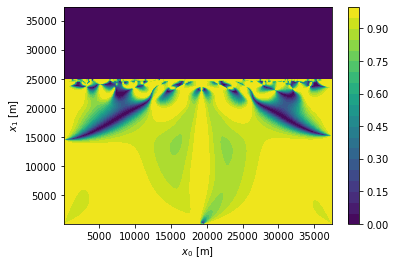

In [98]:
gm=grad(mi, ReducedFunction(domain))
gm0=gm[0]
gm1=gm[1]
lgm0=length(gm0)
lgm1=length(gm1)
R2=safeDiv(inner(gm0,gm1),lgm0*lgm1)**2
#R2=safeDiv(inner(gm0,gm1),lgm0*lgm1)

R2_np=convertToNumpy(R2)
x_np=convertToNumpy(R2.getX())
plt.figure()
contour=plt.tricontourf(x_np[0], x_np[1], R2_np[0], 20)
plt.colorbar(contour)
plt.xlabel('$x_0$ [m]')
plt.ylabel('$x_1$ [m]')

Plot result:

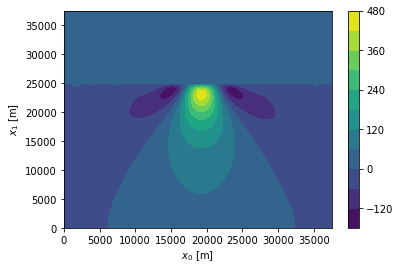

In [99]:
rho=mi[0]*cf.rhodash+cf.rho_ref
rho_np=convertToNumpy(rho)
x_np=convertToNumpy(rho.getX())
plt.figure()
vmax=abs(rho_np).max()*1.01
#contour=plt.tricontourf(x_np[0], x_np[1], rho_np[0], levels=np.linspace(-vmax,vmax,20), cmap='seismic')
contour=plt.tricontourf(x_np[0], x_np[1], rho_np[0], 10)
plt.xlabel('$x_0$ [m]')
plt.ylabel('$x_1$ [m]')
plt.colorbar(contour)

Text(0, 0.5, '$x_1$ [m]')

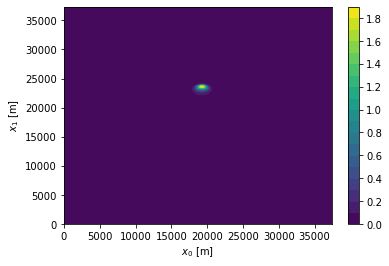

In [100]:
sigma=cf.sigma_ref*exp(mi[1])
sigma_np=convertToNumpy(sigma)
x_np=convertToNumpy(sigma.getX())
plt.figure()
contour=plt.tricontourf(x_np[0], x_np[1], sigma_np[0], 20)
plt.colorbar(contour)
plt.xlabel('$x_0$ [m]')
plt.ylabel('$x_1$ [m]')

Plot the data and recovered data:
    
First we need a `Locator`:

In [101]:
from esys.escript.pdetools import Locator
x0_transect=np.linspace(h0/2, L0-h0/2, NE0)
x_transect=[ (x0, surface_z+h1/2) for x0 in np.linspace(L0/2-L0*0.3, L0/2+L0*0.3, int(NE0*0.6)) ]
transect_locator=Locator(where=ReducedFunction(domain), x=x_transect )
x0_transect=[ x[0] for x in transect_locator.getX() ]

In [102]:
data_g_transect=transect_locator.getValue(data_g*mGal)
datai_g=getGravity(domain, rho)
datai_g_transect=transect_locator.getValue(datai_g*mGal)

Text(0.5, 1.0, 'gravity anomaly over transect @ height 24975 m')

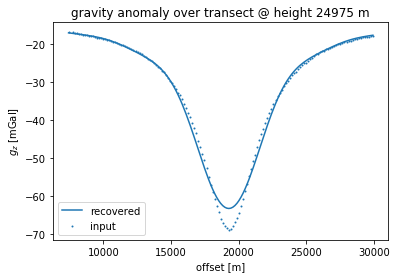

In [103]:
plt.figure()
plt.scatter(x0_transect, data_g_transect, label="input", s=1)
plt.plot(x0_transect, datai_g_transect, label="recovered")
plt.xlabel('offset [m]')
plt.ylabel('$g_z$ [mGal]')
plt.legend()
plt.title("gravity anomaly over transect @ height %g m"%(transect_locator.getX()[0][1]))

In [104]:
data_mt_transect=transect_locator.getValue(1./(cf.omega*Mu0)*abs(data_mt)**2)
datai_mt=getMTTE(domain, f, sigma)
datai_mt_transect=transect_locator.getValue(1./(cf.omega*Mu0)*abs(datai_mt)**2)

Text(0.5, 1.0, 'apparent resistivity over transect @ height 24975 m')

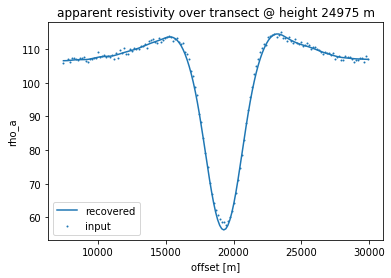

In [105]:
plt.figure()
plt.scatter(x0_transect, data_mt_transect, label="input", s=1)
plt.plot(x0_transect, datai_mt_transect, label="recovered")
plt.xlabel('offset [m]')
plt.ylabel('rho_a')
plt.legend()
plt.title("apparent resistivity over transect @ height %g m"%(transect_locator.getX()[0][1]))

In [106]:
Lsup(mi[1]), Lsup(mi[0])

(5.20150760128974, 0.9071613705826447)